In [1]:
import tensorflow as tf
from tensorflow import keras as keras
print(tf.__version__)

print(keras.__version__)

2.3.1
2.4.0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.callbacks import History

# Transfer learning

<br>

<img src="Grafika/transfer_learning.png" width="550">

**Transfer learning** (transfer "wiedzy") - wykorzystanie nauczonych przez kogoś sieci do naszego problemu. Możliwe dzięki temu, że cechy wykrywane przez sieci w głębokich warstwach mogą być uniwersalne i przydatne w różnych problemach.

### VGG16

In [5]:
from tensorflow.keras.applications import VGG16, InceptionV3
base_model = VGG16(weights='imagenet',include_top=False)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### InceptionV3

In [6]:
inc = InceptionV3()
inc.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

# Zad
Trzeba nadać wymiar wejści anaszej sieci
```python
h,w = 32, 32
```

In [7]:
h,w = 32, 32
model = VGG16(weights='imagenet',include_top=False,input_shape=(h,w,3))

In [8]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [9]:
len(model.layers)

19

# Zad 
Zbudujmy siec z 
* VGG16 dla wejścia h,w = 32, 32
* Flatten
* Dense
* Dense

In [10]:
h,w = 32, 32
model = VGG16(weights='imagenet',include_top=False,input_shape=(h,w,3))

top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dense(4, activation='sigmoid'))

model_transfer = Sequential()
model_transfer.add(model)
model_transfer.add(top_model)

model_transfer.layers[0].trainable = False

model_transfer.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
sequential (Sequential)      (None, 4)                 132356    
Total params: 14,847,044
Trainable params: 132,356
Non-trainable params: 14,714,688
_________________________________________________________________


In [11]:
# model.summary()
# top_model.summary()

In [12]:
from tensorflow.keras.datasets import cifar10
from tensorflow.python.keras.utils import np_utils
# from scipy.misc import toimage

import numpy as np

# load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

nb_classes = 4
n_samples = 7000

X_train, y_train = X_train[np.where(y_train<nb_classes)[0]][:n_samples], y_train[np.where(y_train<nb_classes)[0]][:n_samples]
X_test, y_test = X_test[np.where(y_test<nb_classes)[0]], y_test[np.where(y_test<nb_classes)[0]]

print(X_train.shape)
print(X_test.shape)
print(np.unique(y_train,return_counts=True))
print(X_train[0].shape)

# normalize inputs from 0-255 to 0.0-1.0

X_train = X_train/255
X_test = X_test/255

# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

num_classes = y_test.shape[1]

X_train[0].shape

(7000, 32, 32, 3)
(4000, 32, 32, 3)
(array([0, 1, 2, 3], dtype=uint8), array([1738, 1733, 1779, 1750], dtype=int64))
(32, 32, 3)


(32, 32, 3)

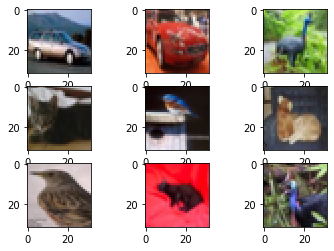

In [13]:
# create a grid of 3x3 images
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i])
plt.show()

In [14]:
X_train.shape[0]/32

218.75

In [15]:
# model.evaluate(X_test,y_test)
history_tr = History()
early_stopping = EarlyStopping(patience=5,monitor="val_loss")
model_transfer.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
model_transfer.fit(X_train, y_train, validation_split=0.25,epochs=100,batch_size=32,callbacks=[early_stopping, history_tr])
model_transfer.evaluate(X_test,y_test)

Epoch 1/100
165/165 [==============================] - 26s 158ms/step - loss: 0.8436 - accuracy: 0.6636 - val_loss: 0.7268 - val_accuracy: 0.7063
Epoch 2/100
165/165 [==============================] - 27s 161ms/step - loss: 0.6582 - accuracy: 0.7354 - val_loss: 0.6925 - val_accuracy: 0.7251
Epoch 3/100
165/165 [==============================] - 27s 163ms/step - loss: 0.6054 - accuracy: 0.7621 - val_loss: 0.7422 - val_accuracy: 0.7040
Epoch 4/100
165/165 [==============================] - 36s 216ms/step - loss: 0.5684 - accuracy: 0.7760 - val_loss: 0.6799 - val_accuracy: 0.7394
Epoch 5/100
165/165 [==============================] - 52s 315ms/step - loss: 0.5235 - accuracy: 0.7937 - val_loss: 0.6906 - val_accuracy: 0.7251
Epoch 6/100
165/165 [==============================] - 41s 249ms/step - loss: 0.5004 - accuracy: 0.8074 - val_loss: 0.6605 - val_accuracy: 0.7349
Epoch 7/100
165/165 [==============================] - 41s 247ms/step - loss: 0.4741 - accuracy: 0.8217 - val_loss: 0.7052 -

[0.6828287839889526, 0.7462499737739563]

In [16]:
np.savetxt("cifar_10_part_conv_Tr_Le_tr.txt", history_tr.history['accuracy'])
np.savetxt("cifar_10_part_conv_Tr_Le_te.txt", history_tr.history['val_accuracy'])

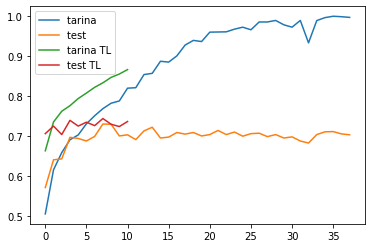

In [17]:
history_11 = np.loadtxt("cifar_10_part_conv_tr.txt")
history_12 = np.loadtxt("cifar_10_part_conv_te.txt")

plt.plot(history_11, label = "tarina ")
plt.plot(history_12, label = "test ")

plt.plot(history_tr.history['accuracy'], label = "tarina TL")
plt.plot(history_tr.history['val_accuracy'], label = "test TL")


plt.legend()
plt.show()